<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairTextureClassification/blob/main/DataProcessing_HairTexture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enviroment

In [2]:
!pip install opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [4]:
!rm -rf ./HairTextureClassification
!git clone https://github.com/CarmenTheodoraCraciun/HairTextureClassification.git

Cloning into 'HairTextureClassification'...
remote: Enumerating objects: 30854, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 30854 (delta 11), reused 5 (delta 5), pack-reused 30835 (from 4)
Receiving objects: 100% (30854/30854), 824.32 MiB | 41.37 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (16606/16606), done.


In [13]:
import os
import cv2
import shutil
import gc
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from collections import Counter

# Data processing

##Resizes the original images

In [7]:
def is_image(file_path):
    try:
        img = cv2.imread(file_path)
        return img is not None
    except:
        return False

def resize_image(img, size):
    """
    Resizes an image using bilinear interpolation.

    Args:
        img: Input image.
        size: Desired size of the output image (width, height).

    Returns:
        Resized image.
    """
    original_height, original_width, _ = img.shape
    new_width, new_height = size
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_width):
        for j in range(new_height):
            #i, j = pixel in the resized image
            # x, y = pixel in the original image
            x = i * (original_width - 1) / (new_width - 1)
            y = j * (original_height - 1) / (new_height - 1)

            # Neighborhood values
            x0 = int(np.floor(x))
            x1 = min(x0 + 1, original_width - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, original_height - 1)

            # Extract the intensity values ​​of neighbors
            Ia = img[y0, x0] # stanga sus
            Ib = img[y0, x1] # drepata sus
            Ic = img[y1, x0] # stanga jos
            Id = img[y1, x1] # dreapta jos

            # Calculates the weight of each neighboring to the final value
            wa = (x1 - x) * (y1 - y)
            wb = (x - x0) * (y1 - y)
            wc = (x1 - x) * (y - y0)
            wd = (x - x0) * (y - y0)

            # The final value of the new pixel
            pixel = wa * Ia + wb * Ib + wc * Ic + wd * Id
            resized_img[j, i] = np.round(pixel).astype(int)

    return resized_img

def preprocess_images(input_dir, size=(96, 96)):
    """
    Resizes images to the specified size and stores them in memory.

    Args:
        input_dir: Directory containing the input images.
        size: Desired size of the output images (width, height).

    Returns:
        images: List of processed images as NumPy arrays.
        labels: List of corresponding labels.
    """
    images = []
    labels = []

    print("Start processing data.")
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if not os.path.isdir(category_dir):
            continue

        num_images = 0  # Contor pentru imagini per categorie
        for idx, img_name in enumerate(os.listdir(category_dir)):
            img_path = os.path.join(category_dir, img_name)

            if is_image(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    img = resize_image(img, size)
                    images.append(img)
                    labels.append(category)
                    num_images += 1
                else:
                    print(f"Failed to load image: {img_path}")
            else:
                print(f"Not an image: {img_path}")

        print(f"Folder {category_dir} has {num_images} images.")

    return np.array(images), np.array(labels)

In [8]:
processed_images, processed_labels = preprocess_images('./HairTextureClassification/originalData', size=(96, 96))

Start processing data.
Folder ./HairTextureClassification/originalData/dreadlocks has 467 images.
Not an image: ./HairTextureClassification/originalData/curly/rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif
Folder ./HairTextureClassification/originalData/curly has 2060 images.
Folder ./HairTextureClassification/originalData/wavy has 331 images.
Folder ./HairTextureClassification/originalData/kinky has 232 images.
Folder ./HairTextureClassification/originalData/straight has 530 images.


## Oversampling for rare classes and Normalization

* Classes like straight, curly, dreadlocks have over more images.
* normalization: to contain only 0 and 1 values


In [9]:
def augumentation_images(images, labels, max_images_per_class=2000, size=(96, 96)):
    class_counts_dict = Counter(labels)
    class_counts = list(class_counts_dict.values())
    class_names = list(class_counts_dict.keys())

    augment_multiplier = {cls: max(1, max_images_per_class // count) for cls, count in zip(class_names, class_counts)}

    print("Augment multipliers:", augment_multiplier)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        img = img[np.newaxis, ...]  # Expand dimensions for datagen flow
        gen = datagen.flow(img, batch_size=1)

        num_augmentations = augment_multiplier[label]

        for _ in range(num_augmentations):
            aug_img = next(gen)[0]
            aug_img = cv2.resize(aug_img, size, interpolation=cv2.INTER_LINEAR)
            augmented_images.append(aug_img)
            augmented_labels.append(label)

    images_augmented = np.array(augmented_images)
    labels_augmented = np.array(augmented_labels)

    print("The new class distribution:", Counter(labels_augmented))
    print(f"Enlarged image dimensions: {images_augmented.shape}")
    print(f"Enlarged label sizes: {labels_augmented.shape}")

    return images_augmented, labels_augmented


In [10]:
images_augmented, labels_augmented = augumentation_images(processed_images, processed_labels, 2000)

Augment multipliers: {np.str_('dreadlocks'): 4, np.str_('curly'): 1, np.str_('wavy'): 6, np.str_('kinky'): 8, np.str_('straight'): 3}
The new class distribution: Counter({np.str_('curly'): 2060, np.str_('wavy'): 1986, np.str_('dreadlocks'): 1868, np.str_('kinky'): 1856, np.str_('straight'): 1590})
Enlarged image dimensions: (9360, 96, 96, 3)
Enlarged label sizes: (9360,)


In [22]:
# augmented_counts = Counter(labels_augmented)
# class_counts = [count for label, count in augmented_counts.items() if label != "curly"]
# mean_class_size = int(np.mean(class_counts))

# counter = Counter(labels_augmented)
# filtered_images, filtered_labels = [], []

# for img, label in zip(images_augmented, labels_augmented):
#     if label == "curly" and counter[label] > mean_class_size:
#         counter[label] -= 1
#     else:
#         filtered_images.append(img)
#         filtered_labels.append(label)

# print(f"Reducere curly at {Counter(filtered_labels)['curly']} images.")

Reducere curly at 1825 images.


In [11]:
def save_images_to_folders(images, labels, images_augmented, labels_augmented, output_dir="HairTextureClassification/processedData"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    class_counts = {}

    for img, label in zip(images, labels):
        assert img.shape[:2] == (96, 96), f"Error: Original image {label} is not 96x96!"
        class_dir = os.path.join(output_dir, label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        class_counts[label] = class_counts.get(label, 0) + 1
        file_name = f"{label}_{class_counts[label]}.png"

        cv2.imwrite(os.path.join(class_dir, file_name), img.astype(np.uint8))

    for img, label in zip(images_augmented, labels_augmented):
        assert img.shape[:2] == (96, 96), f"Error: Augmented image {label} is not 96x96!"
        class_dir = os.path.join(output_dir, label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        class_counts[label] += 1
        file_name = f"{label}_{class_counts[label]}.png"

        cv2.imwrite(os.path.join(class_dir, file_name), img.astype(np.uint8))

    print(f"Saved original and augmented images in {output_dir}")

In [12]:
save_images_to_folders(processed_images, processed_labels, images_augmented, labels_augmented)
shutil.make_archive("processedData", "zip", "./HairTextureClassification/processedData")
files.download("processedData.zip")

Saved original and augmented images in HairTextureClassification/processedData


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

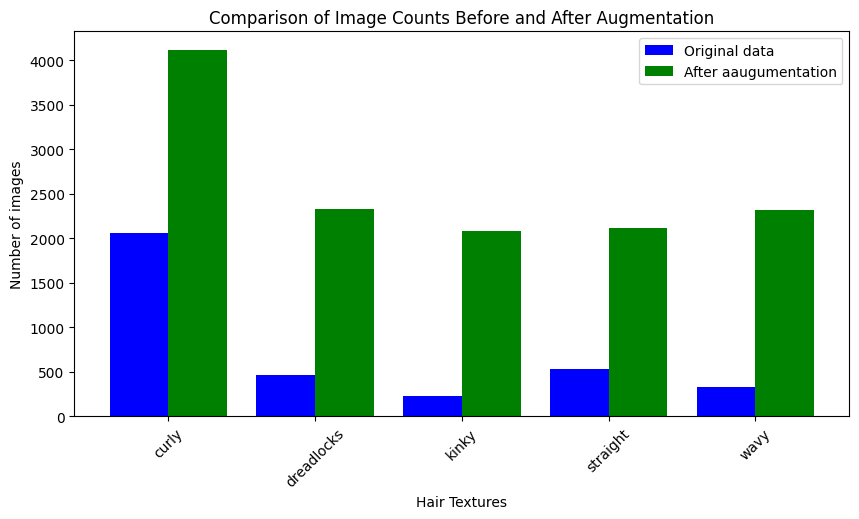

In [15]:
original_counts = Counter(processed_labels)
augmented_counts = Counter(labels_augmented)

final_counts = {label: original_counts[label] + augmented_counts[label] for label in original_counts.keys()}

sorted_labels = sorted(final_counts.keys())

original_values = [original_counts[label] for label in sorted_labels]
final_values = [final_counts[label] for label in sorted_labels]

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(sorted_labels))
width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, original_values, width, label="Original data", color="blue")
plt.bar(x + width/2, final_values, width, label="After aaugumentation", color="green")
plt.xticks(x, sorted_labels, rotation=45)
plt.xlabel("Hair Textures")
plt.ylabel("Number of images")
plt.title("Comparison of Image Counts Before and After Augmentation")
plt.legend()
plt.show()